In [1]:
from helper import Search, query, connections

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap(matrix, annot=True, fmt=".0f", cmap="cividis", figsize=None, **kwargs):
    if figsize:
        plt.subplots(figsize=figsize)
    sns.heatmap(matrix, annot=annot, fmt=fmt, cmap=cmap, **kwargs)

In [2]:
def search():
    return Search("elastipy-example-commits*")

### activity

#### commits per week

<AxesSubplot:xlabel='date'>

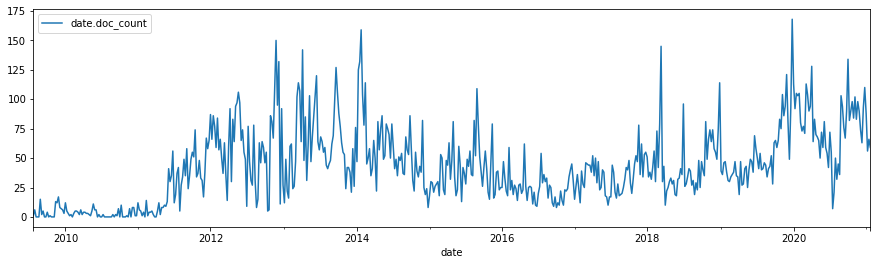

In [30]:
s = search().term("project", "pandas")
agg = s.agg_date_histogram("date", calendar_interval="week")
agg.execute().df(to_index=True).plot(figsize=(15,4))

#### additions/deletions per week

<AxesSubplot:xlabel='date'>

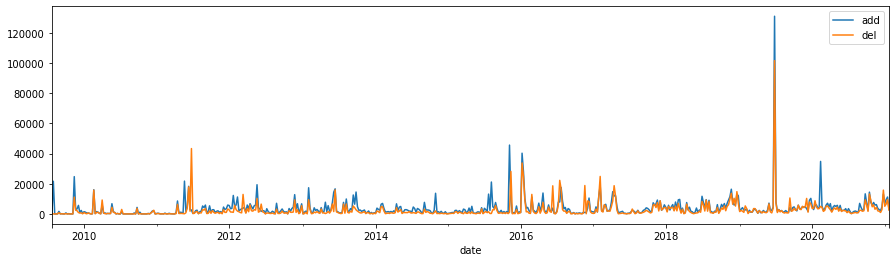

In [142]:
s = search().term("project", "pandas")
agg = s.agg_date_histogram("date", calendar_interval="week")
agg.metric_sum("add", field="changes.additions")
agg.metric_sum("del", field="changes.deletions")
agg.execute().df(to_index=True, exclude="*doc_count").plot(figsize=(15,4))

### authors

#### top 3 authors per year

<AxesSubplot:xlabel='a0'>

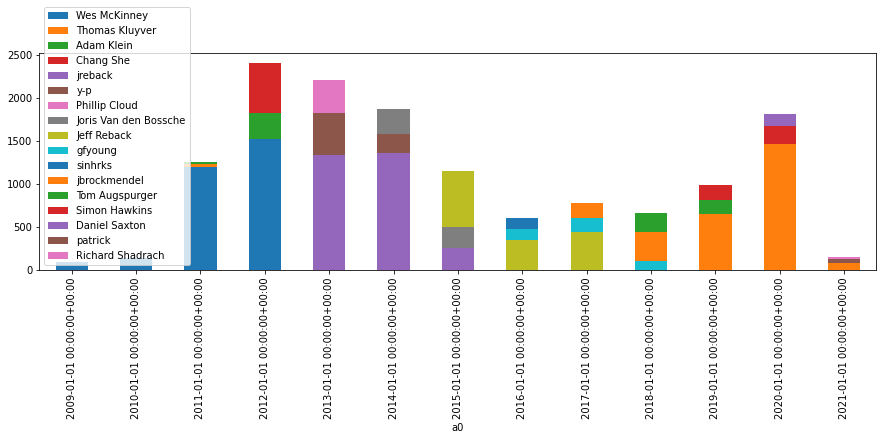

In [65]:
s = search().term("project", "pandas")
agg = s.agg_date_histogram(calendar_interval="year")
agg = agg.agg_terms("author", field="author", size=3)
agg.execute().df(to_index=True, flat="author", exclude="*doc_count").plot.bar(figsize=(15,4), stacked=True)

all authors 2504


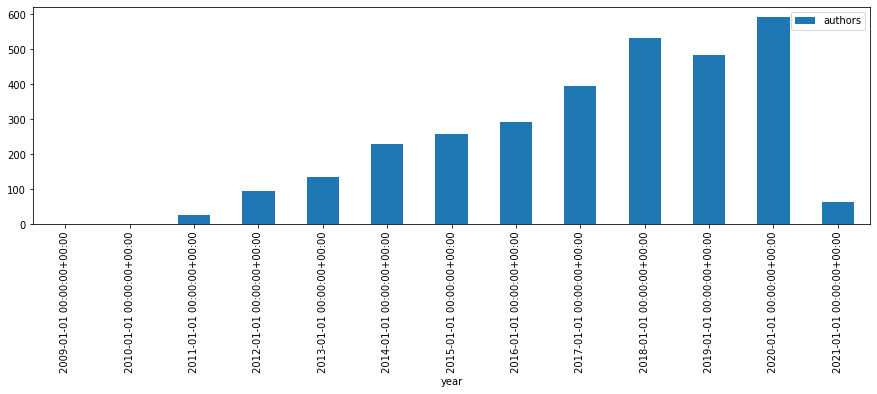

In [104]:
s = search().term("project", "pandas")
global_authors = s.metric_cardinality(field="author", return_self=True)
agg = s.agg_date_histogram("year", calendar_interval="year")
agg = agg.metric_cardinality("authors", field="author")
agg.execute().df(to_index=True, exclude="*doc_count").plot.bar(figsize=(15,4), stacked=True)
print("all authors", next(global_authors.values()))

### messages

#### significant terms per year

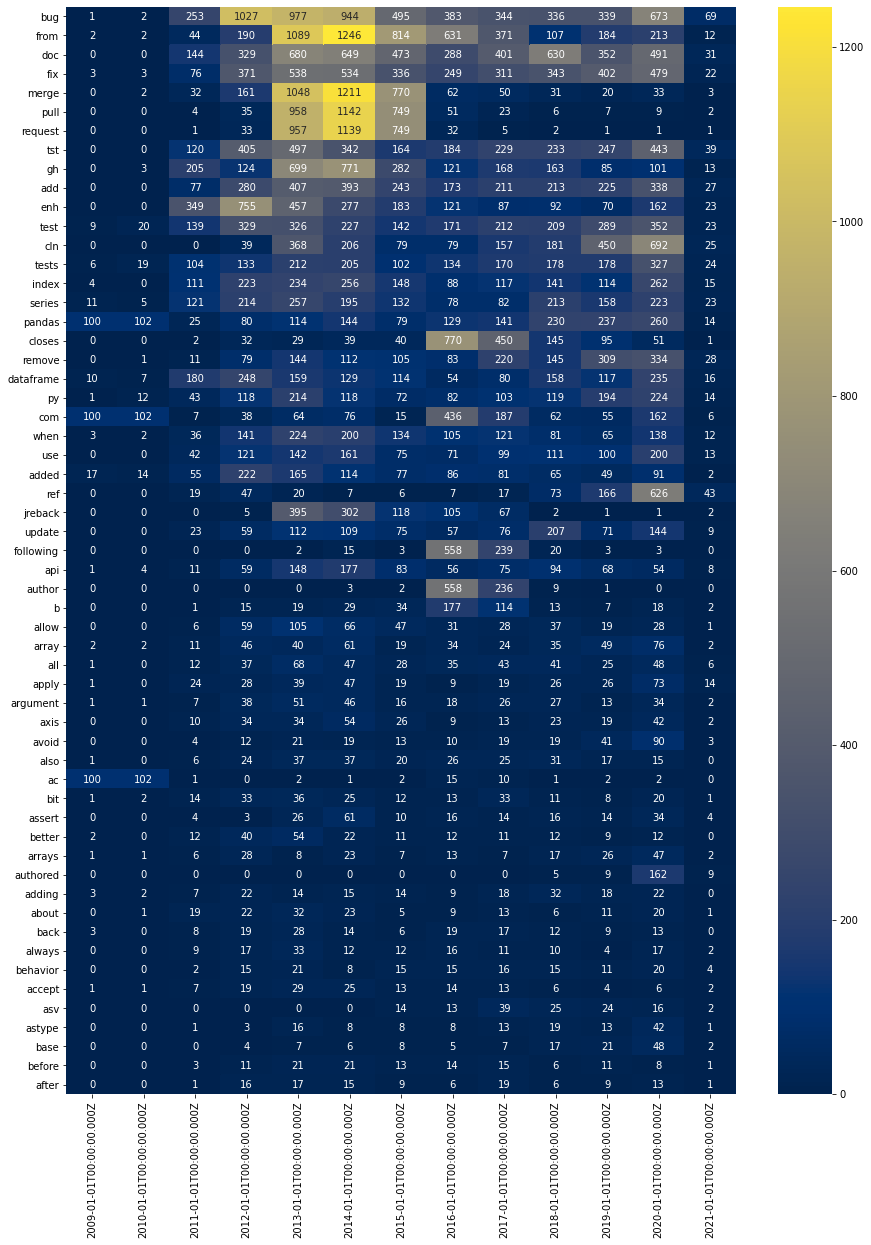

In [95]:
s = search().term("project", "pandas")
keywords = set(s.copy().agg_significant_terms(field="message", size=30, shard_size=1000).execute().keys())
keywords |= set(s.copy().agg_significant_terms(field="message", size=30, shard_size=30000).execute().keys())

agg = s.agg_date_histogram("date", calendar_interval="year")
agg = agg.agg_filters("word", filters={key: query.Term("message", key) for key in keywords})
df = agg.execute().df_matrix().transpose()
df["sum"] = df.sum(axis=1)
df.sort_values("sum", inplace=True, ascending=False)
df.pop("sum")
heatmap(df, figsize=(15, 20))


### files

#### top 50 edited files per year

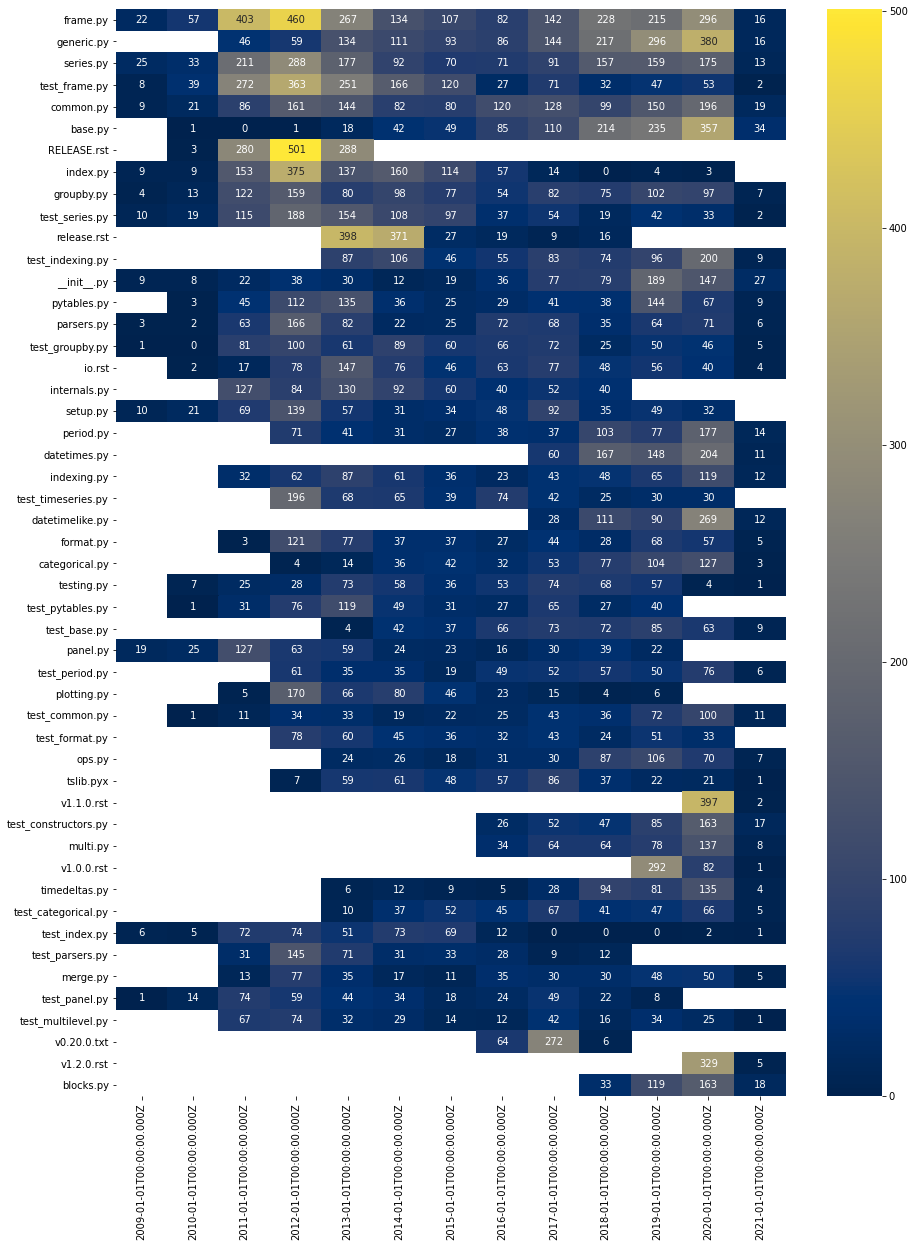

In [145]:
s = search().term("project", "pandas")
agg = s.agg_terms(field="changes.file", size=50)
agg = agg.agg_date_histogram("date", calendar_interval="year")
df = agg.execute().df_matrix()
heatmap(df, figsize=(15, 20))

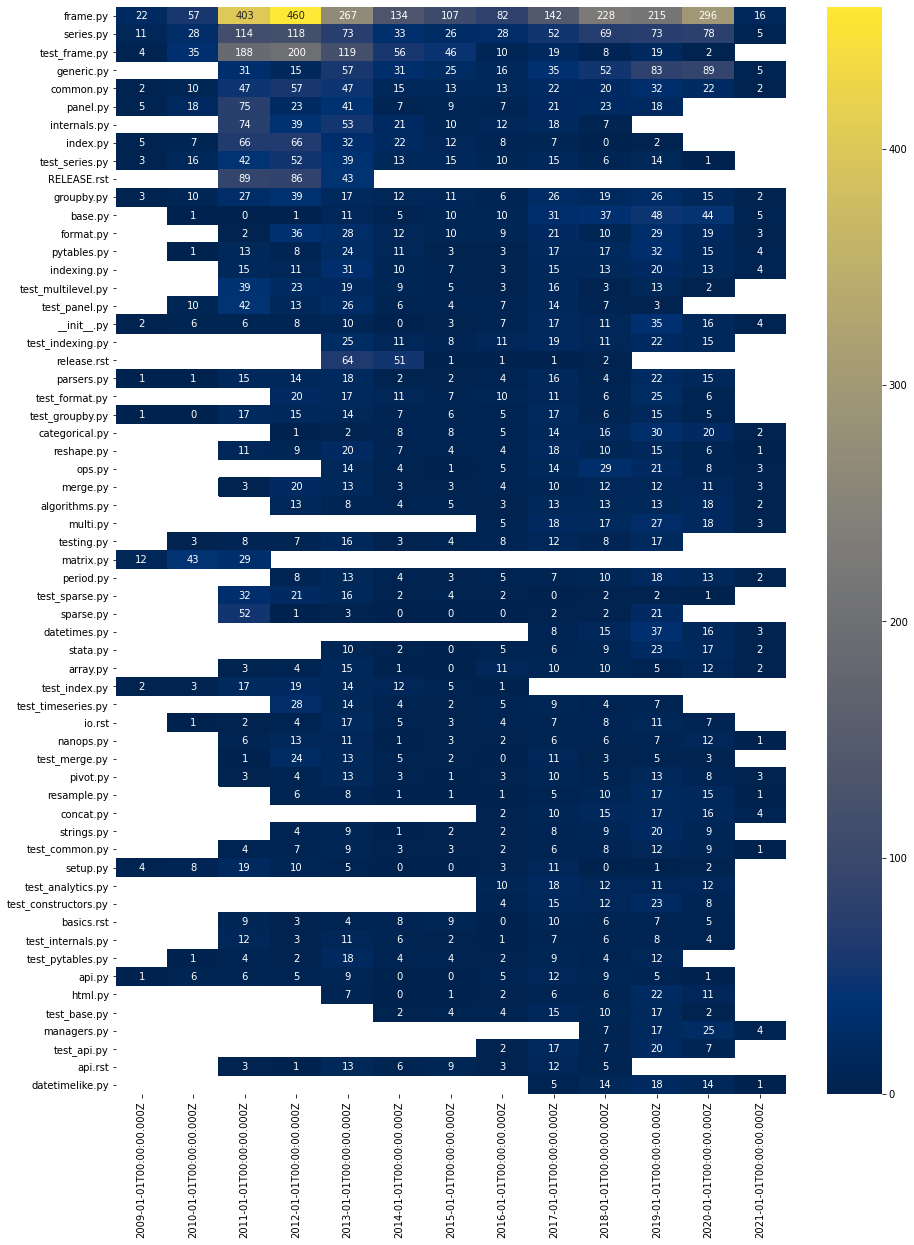

In [131]:
s = search().term("project", "pandas")
s = s.query_string("changes.file: frame.py")
agg = s.agg_terms(field="changes.file", size=60)
agg = agg.agg_date_histogram("date", calendar_interval="year")
df = agg.execute().df_matrix()#.transpose()
heatmap(df, figsize=(15, 20))


In [36]:
s = search()
agg = s.agg_filters(filters={
    "fix": query.Match(field="message", query="fix"),
    "merge": query.Match(field="message", query="merge"),
    "bug": query.Match(field="message", query="bug"),
})
agg = agg.agg_date_histogram(calendar_interval="year")
agg.execute().dump.heatmap()

                         ┌─────┼─────────┼─────────┼──────┐ ██ 1211.0
                         │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ ▓▓ 1110.167
                         │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ ▒▒ 1009.333
2021-01-01T00:00:00.000Z ┼ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ ┼ ██ 908.5
                         │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ ▓▓ 807.667
                         │ ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ │ ▒▒ 706.833
                         │ ▒▒▒▒▒▒▒▒▒▒▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░ │ ██ 606.0
                         │ ▒▒▒▒▒▒▒▒▒▒▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░ │ ▓▓ 505.167
2020-01-01T00:00:00.000Z ┼ ▒▒▒▒▒▒▒▒▒▒▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░ ┼ ▒▒ 404.333
                         │ ▒▒▒▒▒▒▒▒▒▒▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░ │ ██ 303.5
                         │ ▒▒▒▒▒▒▒▒▒▒▓▓▓▓▓▓▓▓▓▓░░░░░░░░░░ │ ▓▓ 202.667
                         │ ██████████▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ │ ▒▒ 101.833
                         │ ██████████▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ │ ░░ 1.0
2019-01-01T00:00:00.000Z ┼ ██████████▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ ┼
                         │

In [31]:
s = search().term("project", "pandas")
s = s.match("message", "fix")
s.execute().dump.documents()

[
  {
    "hash": "8a9bc9ed7da669c9d391579a59da003b81539bb1",
    "author": "Adam Klein",
    "author_email": "adamklein@gmail.com",
    "timestamp": "2012-01-17T13:18:49-05:00",
    "message": "FIX: multiindex, comma fix\n",
    "changes": [
      {
        "filepath": "pandas/core/index.py",
        "file": "index.py",
        "additions": 1,
        "deletions": 1
      }
    ],
    "timestamp_hour": 13,
    "timestamp_weekday": "2 Tuesday",
    "project": "pandas"
  },
  {
    "hash": "68db2d26ddb5f95de4254d61b850d3dcaf6ce717",
    "author": "patrick",
    "author_email": "61934744+phofl@users.noreply.github.com",
    "timestamp": "2021-01-05T21:52:32-05:00",
    "message": "Fix bug on master (#38987)\n\n* Fix bug on master\n\n* Fix indent problem",
    "changes": [
      {
        "filepath": "doc/source/user_guide/io.rst",
        "file": "io.rst",
        "additions": 5,
        "deletions": 7
      },
      {
        "filepath": "pandas/tests/io/test_html.py",
        "file": "

KeyboardInterrupt: 